# Unidad 1 – Fases 1 a 3 (CRISP-DM)

## Proyecto: Trayectorias escolares – Atraso educativo (Perú, 2021–2024)

-Business Understanding → Data Understanding → Data Preparation
-  **Integrantes:** [Luis Lucero - Alexis Del Castillo - May Attilano]  


## Fase 1. Business Understanding

### 🎯 1. Objective

Construir un sistema analítico de **predicción de riesgo crediticio** para el **programa Reactiva Perú** que (a) caracterice y explique los patrones de **reprogramación del crédito (REPRO)** por **sector económico, departamento y entidad otorgante**, y (b) **estime para cada empresa la probabilidad de REPRO = 1** usando variables disponibles (`sector_economico`, `departamento`, `entidad_otorgante_credito`, `saldo_insoluto`, `cobertura_saldo_insoluto`). El propósito es generar **evidencia accionable** para **priorizar seguimiento y mitigación de riesgo** (gestión de cartera, alertas tempranas y coordinación con entidades financieras) en segmentos con mayor probabilidad de reprogramación.

#### Success criteria (SC)


##### Técnico

* **Calidad de datos**: cobertura de `REPRO` y campos clave ≥ **95%** tras limpieza/estandarización (incl. mapeo `SI/NO → 1/0` y diccionario de alias).
* **Modelo (logística L1 + CV estratificada)**

  * **ROC AUC ≥ 0.75** en test.
  * **F1 ≥ 0.62** y **Recall ≥ 0.60** en la clase positiva (REPRO=1) con umbral 0.50.
  * **Calibración**: Brier score ≤ **0.19** o slope en **\[0.9, 1.1]**.
  * **Parquedad (L1)**: ≤ **25%** de *features* con coeficiente ≠ 0.
  * **Estabilidad**: signo de coeficientes clave consistente en ≥ **80%** de los *folds*.
* **Reportabilidad**: entrega de curva **ROC**, matriz de confusión, **top coeficientes** por |β| y EDA (distribución de REPRO; barras por **departamento/sector**; REPRO×sector).

##### De negocio

* **Priorización operativa**: focalizar acciones en el **top 20%** de empresas por riesgo $\hat{p}(\text{REPRO}=1)$ con **cobertura ≥ 80%** (contacto/seguimiento) dentro del mes de despliegue.
* **Reducción de riesgo** (en unidades priorizadas, período siguiente):

  * **–1.5 pp** o más en la tasa de REPRO **o**
  * **–10%** o más en el **saldo\_insoluto** promedio del subgrupo de alto riesgo.
* **Gestión y transparencia**: **tablero mensual** con tasas de REPRO y ranking de riesgo por **entidad otorgante/sector/departamento**, con exportables.
* **Adopción**: ≥ **2 sesiones/mes** de uso por áreas responsables y ≥ **2** intervenciones/acciones documentadas por ciclo.
* **SLA**: pipeline actualizado y publicado **mensualmente** con bitácora de calidad de datos.


## Fase 2. Data Understanding

### 📥 2. Data collection 

In [9]:
import pandas as pd
import numpy as np

# Lista de archivos Excel que quieres unir
archivos = [
    "reactiva_peru_2022.xlsx",
]

# Leer y concatenar todos los Excel (primera hoja por defecto)
df = pd.concat([pd.read_excel(f) for f in archivos], ignore_index=True)

# Ver tamaño del dataset resultante
print(df.shape)


(446784, 9)


In [7]:
# Resumen general
df.info()

print('df.columns:', df.columns)
print('df.shape:', df.shape)

# Mostrar primeras 10 filas
df.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446784 entries, 0 to 446783
Data columns (total 9 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   ORDEN                                    446784 non-null  int64  
 1   RAZÓN SOCIAL                             446784 non-null  object 
 2   RUC/DNI                                  446784 non-null  int64  
 3   SECTOR ECONÓMICO                         446784 non-null  object 
 4   NOMBRE DE ENTIDAD OTORGANTE DEL CRÉDITO  446784 non-null  object 
 5   DEPARTAMENTO                             446784 non-null  object 
 6   SALDO INSOLUTO (S/)                      446784 non-null  float64
 7   COBERTURA DEL SALDO INSOLUTO(S/)         446784 non-null  float64
 8   REPRO                                    446784 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 30.7+ MB
df.columns: Index(['ORDEN', 'RAZÓN SOCIAL', 'R

,ORDEN,RAZÓN SOCIAL,RUC/DNI,SECTOR ECONÓMICO,NOMBRE DE ENTIDAD OTORGANTE DEL CRÉDITO,DEPARTAMENTO,SALDO INSOLUTO (S/),COBERTURA DEL SALDO INSOLUTO(S/),REPRO
0,1,_x001A_USTA SAGRADA SAC,20553879150,HOTELES Y RESTAURANTES,BANCO BBVA PERU,LIMA,188862.88,179419.7360,NO
1,2,2L SOLUCIONES S.A.C.,20524693250,"ACTIV. INMOBILIARIAS, EMPRESARIALES ALQ.",CRÉDITO,LIMA,124896.00,118651.2000,SI
2,3,3P INVERSIONES S.A.C.,20551286348,COMERCIO,CRÉDITO,LIMA,75295.93,71531.1335,NO
3,4,A & G MISTI CONSTRUCTORESS.A.C,20542311488,MINERIA,CRÉDITO,SAN MARTIN,73613.32,69932.6540,NO
4,5,A Y N CALZADOS S.A.C.,20601959217,INDUSTRIA MANUFACTURERA,CRÉDITO,LIMA,71486.63,67912.2985,NO
5,6,ABRAINO E.I.R.L.,20601644011,COMERCIO,CRÉDITO,LIMA,85828.24,81536.8280,NO
6,7,ACERIAS TEFOLCA SAC,20601806461,COMERCIO,CRÉDITO,LIMA,126497.78,120172.8910,NO
7,8,ACR IMPORTACIONES GENERALES EIRL,20524657296,COMERCIO,CRÉDITO,LIMA,87493.66,83118.9770,NO
8,9,AD MY PLAZA S.A.C.,20603720921,COMERCIO,CRÉDITO,LIMA,139910.00,132914.5000,SI
9,10,ADMINISTRACIONES PESQUERAS E.I.R.L.,20603216335,PESCA,CRÉDITO,LIMA,90510.00,85984.5000,SI


### 📊 3. Descriptive analysis

#### 3.1 Análisis descriptivo

In [10]:
# Resumen estadístico de todas las variables
df.describe(include="all").T   # incluye categóricas y numéricas

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ORDEN,446784.0,NaN,NaN,NaN,223392.5,128975.575671,1.0,111696.75,223392.5,335088.25,446784.0
RAZÓN SOCIAL,446784,446345,DEL PILAR MARIA,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RUC/DNI,446784.0,NaN,NaN,NaN,5371943399.393656,8395261225.536915,60.0,25866841.0,45204950.5,10406432083.0,20606509066.0
SECTOR ECONÓMICO,446784,14,COMERCIO,212073,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NOMBRE DE ENTIDAD OTORGANTE DEL CRÉDITO,446784,28,MIBANCO,227378,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEPARTAMENTO,446784,25,LIMA,134334,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SALDO INSOLUTO (S/),446784.0,NaN,NaN,NaN,80044.222082,407993.771228,1.77,3643.21,9763.64,26598.9175,11582331.81
COBERTURA DEL SALDO INSOLUTO(S/),446784.0,NaN,NaN,NaN,72955.76314,350285.679328,1.7346,3570.3458,9568.3672,26037.43135,9265865.448
REPRO,446784,2,NO,312109,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Separar los datos según sus tipos de variables
numeric_data = df.select_dtypes(include=[np.number])     # numéricas
categor_data = df.select_dtypes(exclude=[np.number])     # categóricas (incluye fechas como objeto)

print("There are {} numeric and {} categorical columns in train data".format(
    numeric_data.shape[1], categor_data.shape[1]
))

There are 4 numeric and 5 categorical columns in train data


In [10]:
# Resumen estadístico de variables numéricas
numeric_data.describe().T

,count,mean,std,min,25%,50%,75%,max
cod_mod,2205115.0,1.120409e+06,840818.247191,1506.0,477422.0,929976.0,1522093.0,9999610.0
anexo,2205115.0,5.895384e-05,0.008302,0.0,0.0,0.0,0.0,2.0
Edad,2205109.0,8.936967e+00,4.380616,0.0,5.0,9.0,12.0,18.0
TotalEstudiantes,2205115.0,1.489916e+01,28.756441,1.0,2.0,5.0,14.0,831.0
Discapacidad,2205115.0,1.411310e-01,0.431554,0.0,0.0,0.0,0.0,17.0
Mujer,2205115.0,7.321303e+00,15.229591,0.0,1.0,2.0,7.0,557.0
Hombre,2205115.0,7.577855e+00,15.417363,0.0,1.0,3.0,7.0,831.0
Venezolanos,2205115.0,2.346358e-01,1.392426,0.0,0.0,0.0,0.0,63.0
Peruanos,2205115.0,1.456547e+01,28.011286,0.0,2.0,5.0,14.0,830.0
Extranjeros,2205115.0,9.905470e-02,0.491253,0.0,0.0,0.0,0.0,33.0


In [11]:
# Resumen estadístico de variables categóricas
categor_data.describe(include="all").T


,count,unique,top,freq
Nombre,2205115,57151,JOSE CARLOS MARIATEGUI,5033
gestion,2205115,3,Pública de gestión directa,1690426
id_nivel,2205115,6,B0,1095268
dsc_nivel,2205115,6,Primaria,1095268
TipoDiscaIntegrada,265103,16,Intelectual,78689


In [12]:
# Ejemplo: conteo de valores únicos en variables categóricas de tu dataset real
for col in ['gestion', 'dsc_nivel', 'TipoDiscalIntegrada', 'DNI_validado']:
    if col in df.columns:
        print(f"\n{col}:\n", df[col].value_counts(dropna=False))

# Conteo de la variable objetivo (ejemplo: atraso total)
if "tot_atraso" in df.columns:
    print("\nVariable objetivo (tot_atraso):")
    print(df["tot_atraso"].value_counts(dropna=False))


gestion:
 gestion
Pública de gestión directa    1690426
Privada                        480913
Pública de gestión privada      33776
Name: count, dtype: int64

dsc_nivel:
 dsc_nivel
Primaria                   1095268
Secundaria                  498377
Inicial - Jardín            404845
Inicial no escolarizado     174050
Inicial - Cuna-Jardín        32343
Inicial - Cuna                 232
Name: count, dtype: int64

DNI_validado:
 DNI_validado
1      506484
2      231560
3      173192
4      137953
5      110478
        ...  
503         1
645         1
674         1
604         1
539         1
Name: count, Length: 587, dtype: int64

Variable objetivo (tot_atraso):
tot_atraso
0     1840694
1      204142
2       60713
3       30859
4       18863
       ...   
83          1
96          1
77          1
75          1
88          1
Name: count, Length: 95, dtype: int64


#### 3.2 Análisis descriptivo (gráficos)

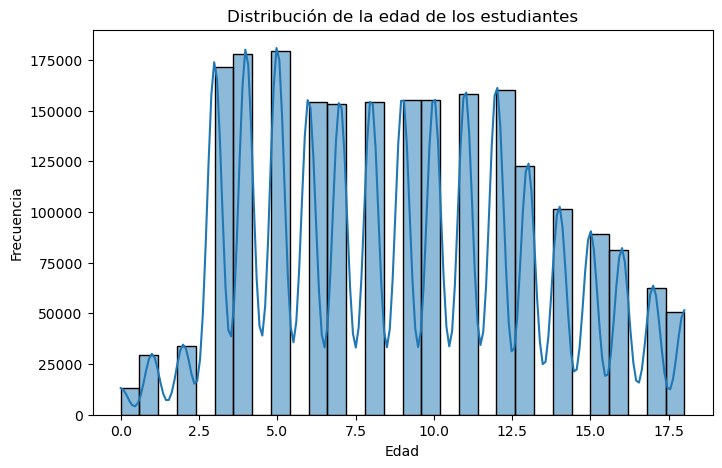

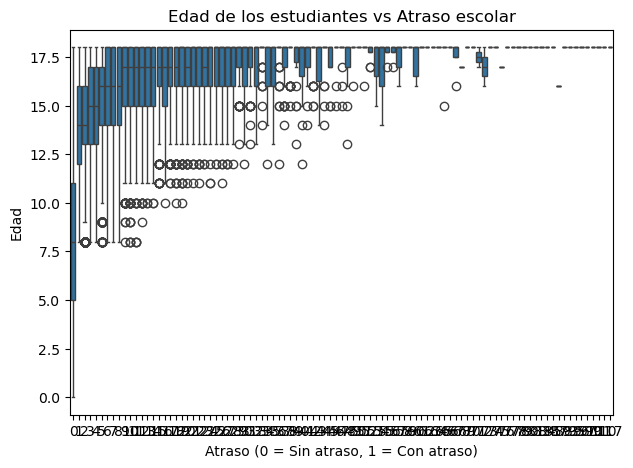

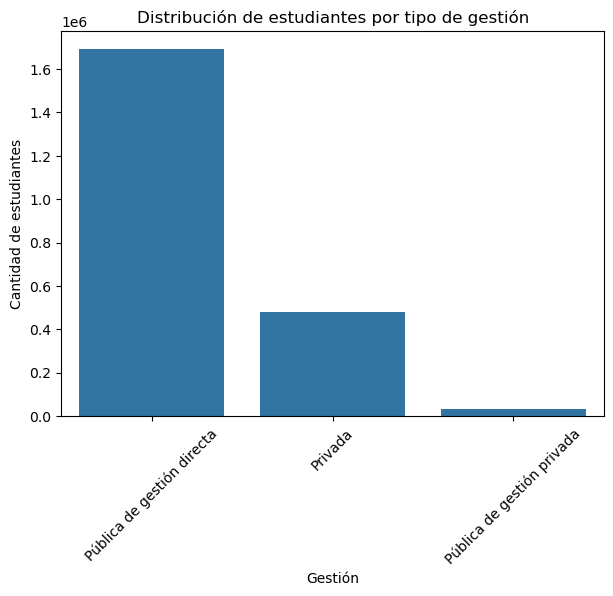

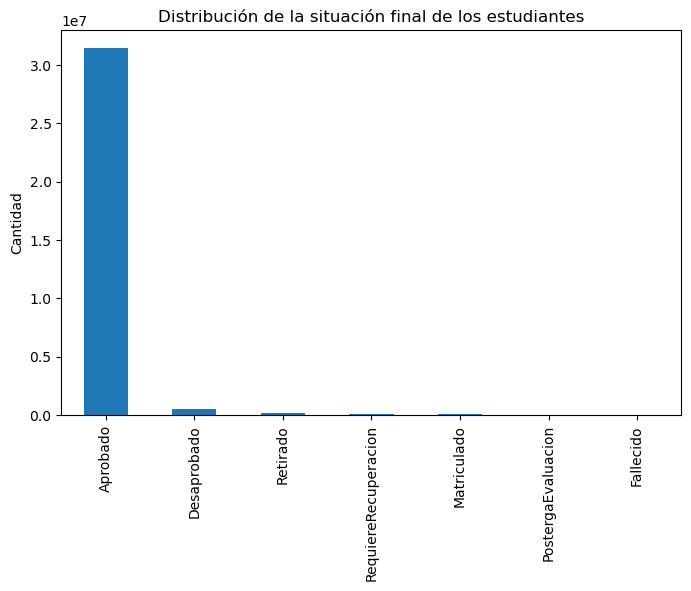

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograma de edad de estudiantes
plt.figure(figsize=(8,5))
sns.histplot(df['Edad'], bins=30, kde=True)
plt.title("Distribución de la edad de los estudiantes")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.show()

# Boxplot de edad por situación de atraso
plt.figure(figsize=(7,5))
sns.boxplot(x='tot_atraso', y='Edad', data=df)
plt.title("Edad de los estudiantes vs Atraso escolar")
plt.xlabel("Atraso (0 = Sin atraso, 1 = Con atraso)")
plt.ylabel("Edad")
plt.show()

# Conteo por gestión de la institución educativa
plt.figure(figsize=(7,5))
sns.countplot(data=df, x='gestion', order=df['gestion'].value_counts().index)
plt.title("Distribución de estudiantes por tipo de gestión")
plt.xlabel("Gestión")
plt.ylabel("Cantidad de estudiantes")
plt.xticks(rotation=45)
plt.show()

# Conteo de situación final (Aprobado, Desaprobado, etc.)
plt.figure(figsize=(8,5))
cols_situacion = ['Aprobado','Desaprobado','Retirado','Fallecido',
                  'RequiereRecuperacion','Matriculado','PostergaEvaluacion']
df[cols_situacion].sum().sort_values(ascending=False).plot(kind='bar')
plt.title("Distribución de la situación final de los estudiantes")
plt.ylabel("Cantidad")
plt.show()

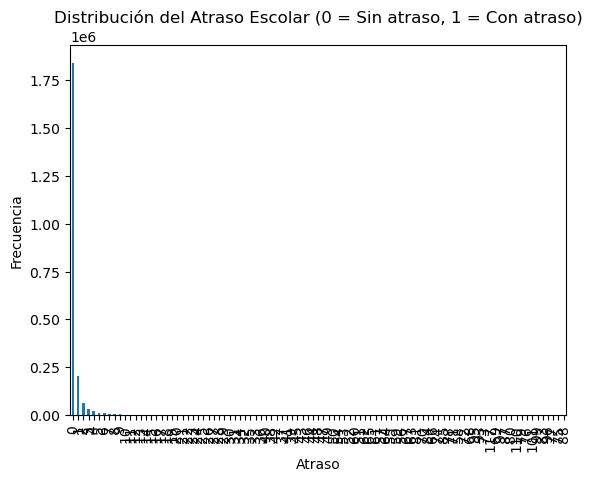

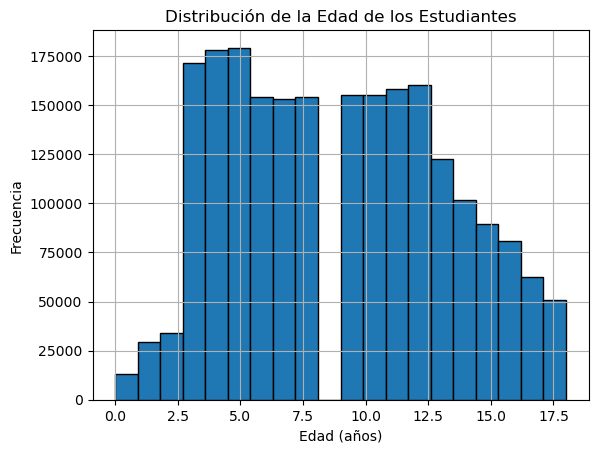

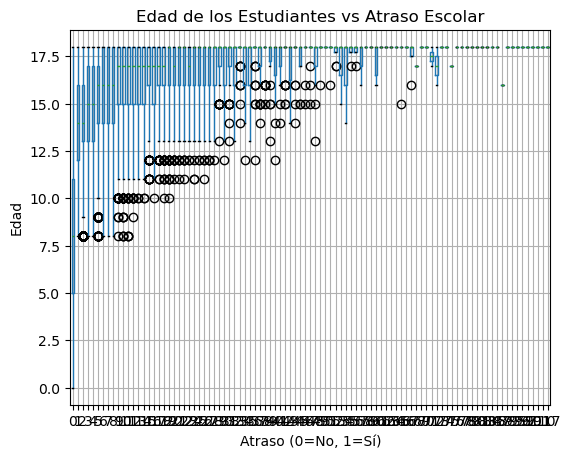

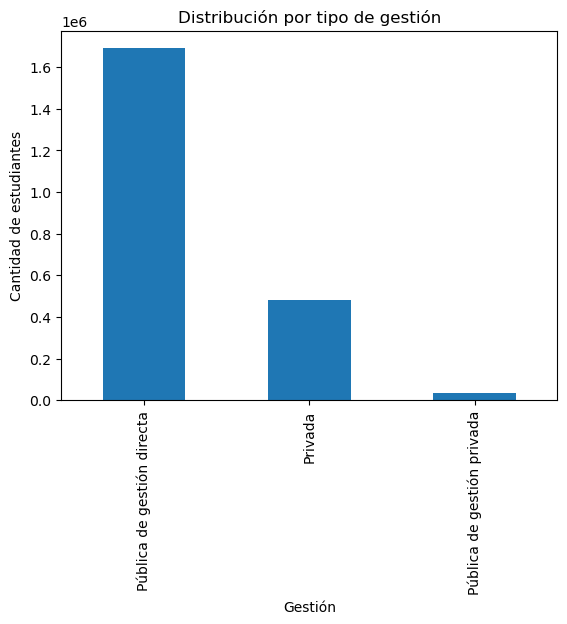

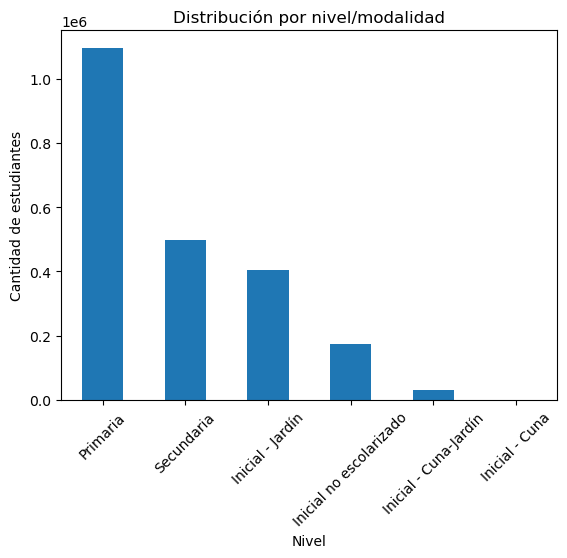

In [16]:
import matplotlib.pyplot as plt

# Conteo de la variable objetivo: atraso (0 = sin atraso, 1 = con atraso)
df['tot_atraso'].value_counts().plot(kind='bar')
plt.title('Distribución del Atraso Escolar (0 = Sin atraso, 1 = Con atraso)')
plt.xlabel('Atraso')
plt.ylabel('Frecuencia')
plt.show()

# Histograma de Edad de estudiantes
df["Edad"].hist(bins=20, edgecolor='black')
plt.title("Distribución de la Edad de los Estudiantes")
plt.xlabel("Edad (años)")
plt.ylabel("Frecuencia")
plt.show()

# Boxplot de edad por atraso
df.boxplot(column="Edad", by="tot_atraso", figsize=(6,5))
plt.title("Edad de los Estudiantes vs Atraso Escolar")
plt.suptitle("")  # para quitar el título extra de pandas
plt.xlabel("Atraso (0=No, 1=Sí)")
plt.ylabel("Edad")
plt.show()

# Conteo por tipo de gestión
df["gestion"].value_counts().plot(kind="bar")
plt.title("Distribución por tipo de gestión")
plt.xlabel("Gestión")
plt.ylabel("Cantidad de estudiantes")
plt.show()

# Conteo por nivel/modalidad
df["dsc_nivel"].value_counts().plot(kind="bar")
plt.title("Distribución por nivel/modalidad")
plt.xlabel("Nivel")
plt.ylabel("Cantidad de estudiantes")
plt.xticks(rotation=45)
plt.show()


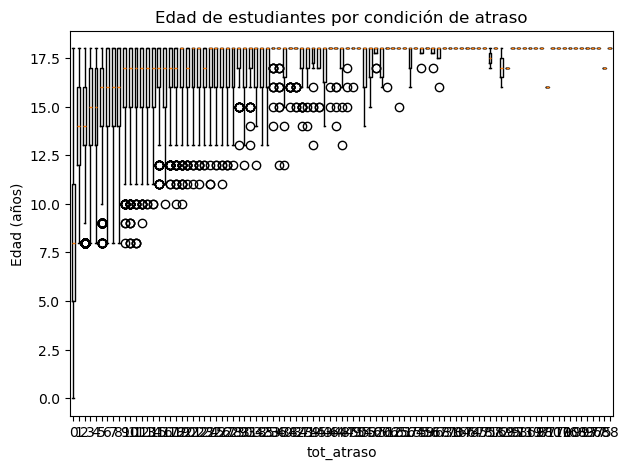

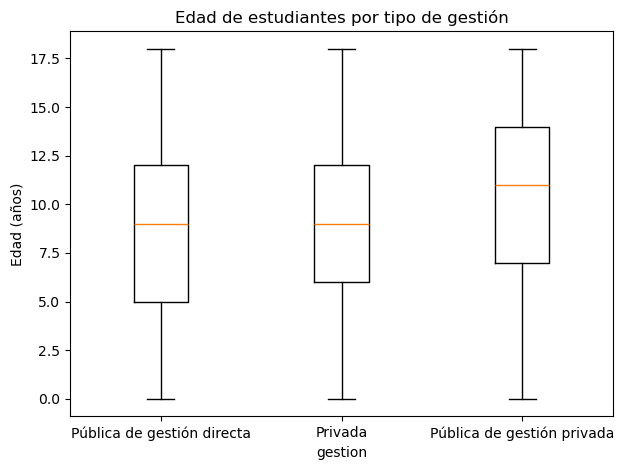

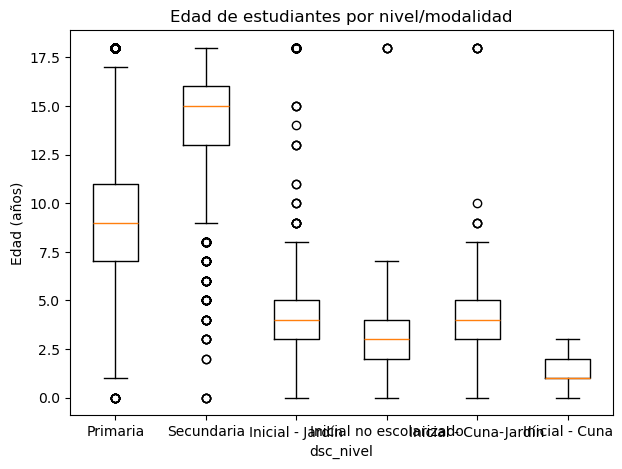

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# === 1) Utilidad: buscar una columna "parecida" en df.columns ===
def find_col(df, candidates):
    cols = [c.lower().strip() for c in df.columns]
    for cand in candidates:
        cand_l = cand.lower().strip()
        for i, c in enumerate(cols):
            if cand_l == c:
                return df.columns[i]
        for i, c in enumerate(cols):
            if cand_l in c:     # coincidencia parcial
                return df.columns[i]
    return None

# === 2) Función genérica para boxplot de numérica vs categórica ===
def boxplot_num_vs_cat(df, num_candidates, cat_candidates, labels_map=None, title=None, y_label=None):
    num_col = find_col(df, num_candidates)
    cat_col = find_col(df, cat_candidates)
    if num_col is None or cat_col is None:
        print("No pude encontrar columnas. num_col:", num_col, "cat_col:", cat_col)
        print("Disponibles:", df.columns.tolist())
        return
    
    # preparar datos
    d = df[[num_col, cat_col]].dropna()
    # Si el categórico es binario numérico (0/1), mapea etiquetas
    if labels_map and d[cat_col].nunique() <= 3:
        # Orden por clave si es 0/1 o texto específico
        ordered = []
        for k in labels_map.keys():
            ordered.append(d.loc[d[cat_col] == k, num_col].values)
        tick_labels = list(labels_map.values())
    else:
        # Agrupa por cada categoría existente
        cats = d[cat_col].value_counts().index.tolist()
        ordered = [d.loc[d[cat_col] == c, num_col].values for c in cats]
        tick_labels = [str(c) for c in cats]

    # Boxplot con el parámetro actualizado (Matplotlib ≥3.9)
    plt.figure(figsize=(7,5))
    plt.boxplot(ordered, tick_labels=tick_labels, showfliers=True)
    plt.title(title if title else f'{num_col} por {cat_col}')
    plt.xlabel(cat_col)
    plt.ylabel(y_label if y_label else num_col)
    plt.show()

# ========== EJEMPLOS ADAPTADOS A TU TEMA (elige el que aplique) ==========

# A) Edad vs atraso (binario): tot_atraso en {0,1}
boxplot_num_vs_cat(
    df,
    num_candidates=["Edad","edad"],
    cat_candidates=["tot_atraso","atraso","sobreedad","rezago"],
    labels_map={0: "SIN ATRASO", 1: "CON ATRASO"},
    title="Edad de estudiantes por condición de atraso",
    y_label="Edad (años)"
)

# B) Edad vs gestión (pública/privada…)
boxplot_num_vs_cat(
    df,
    num_candidates=["Edad","edad"],
    cat_candidates=["gestion","tipo_gestion","gestion_ie"],
    title="Edad de estudiantes por tipo de gestión",
    y_label="Edad (años)"
)

# C) Edad vs nivel/modalidad
boxplot_num_vs_cat(
    df,
    num_candidates=["Edad","edad"],
    cat_candidates=["dsc_nivel","nivel","modalidad"],
    title="Edad de estudiantes por nivel/modalidad",
    y_label="Edad (años)"
)


#### 3.3 Análisis exploratorio (con estadísticas): Correlaciones y cruces de variables

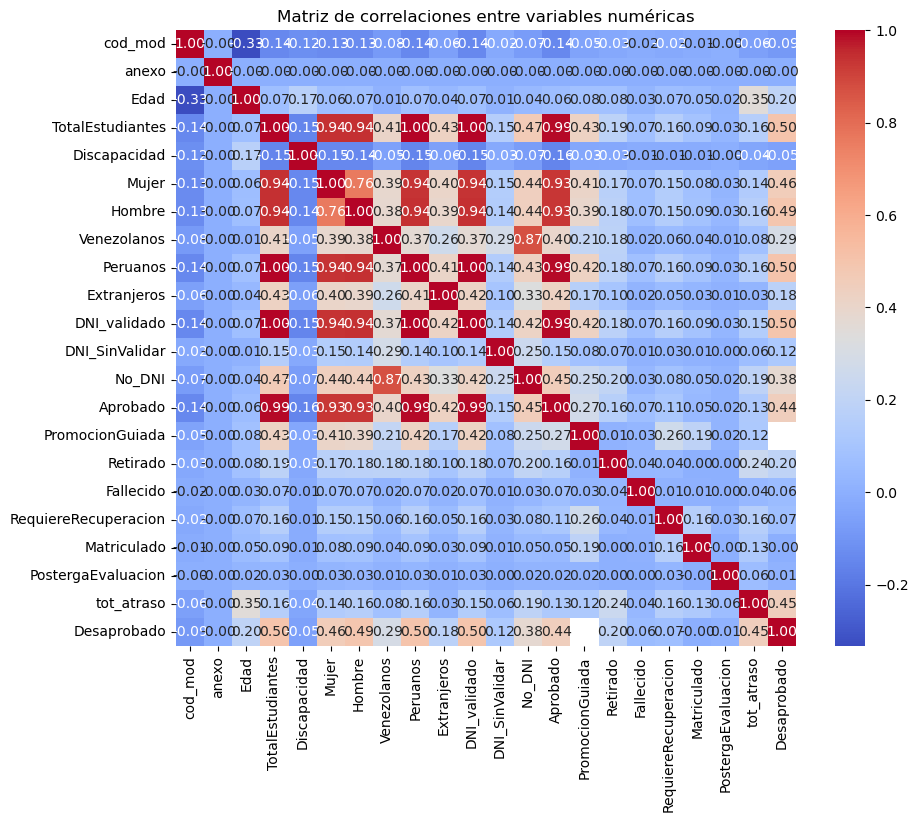

tot_atraso,0,1,2,3,4,5,6,7,8,9,...,87,88,93,95,96,97,99,101,110,117
dsc_nivel,,,,,,,,,,,,,,,,,,,,,
Inicial - Cuna,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Inicial - Cuna-Jardín,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Inicial - Jardín,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Inicial no escolarizado,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Primaria,83.829985,11.146861,2.613607,1.054993,0.526173,0.305496,0.177308,0.105545,0.072950,0.049120,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Secundaria,62.414798,16.464243,6.438299,3.873373,2.628532,1.847999,1.329917,0.992622,0.760468,0.609378,...,0.000201,0.000201,0.000201,0.000201,0.000201,0.000201,0.000201,0.000201,0.000201,0.000201


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# =============================
# Correlaciones numéricas
# =============================
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlaciones entre variables numéricas")
plt.show()

# =============================
# Cruce de variables categóricas con el objetivo
# Ejemplo: gestión vs atraso
# =============================
pd.crosstab(df['gestion'], df['tot_atraso'], normalize='index') * 100

# Otro ejemplo: nivel/modalidad vs atraso
pd.crosstab(df['dsc_nivel'], df['tot_atraso'], normalize='index') * 100


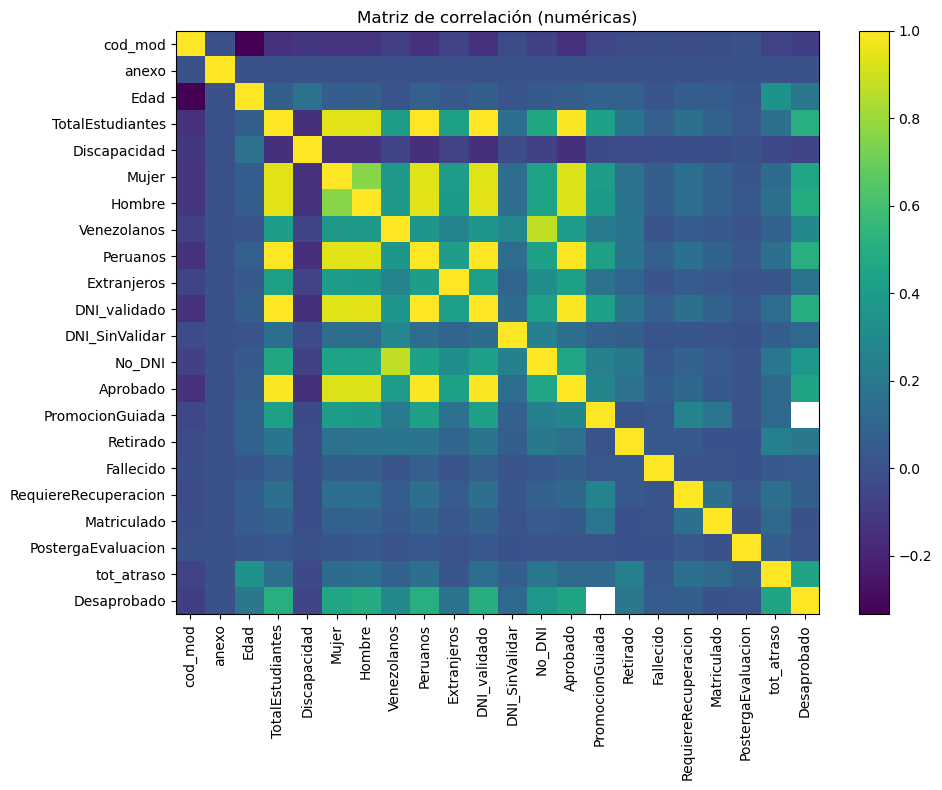

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Seleccionar columnas numéricas
num_cols = df.select_dtypes(include=['int64','float64']).columns
corr = df[num_cols].corr()

plt.figure(figsize=(10,8))
im = plt.imshow(corr, interpolation='nearest', aspect='auto', cmap='viridis')

plt.title('Matriz de correlación (numéricas)')
plt.colorbar(im)

# Poner etiquetas de variables en los ejes
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)

plt.tight_layout()
plt.show()


#### 3.4 Diagnóstico de calidad inicial 

=== Valores faltantes por columna (top 30) ===
TipoDiscaIntegrada      1940012
Desaprobado             1125144
PromocionGuiada         1079971
Edad                          6
DNI_validado                  0
tot_atraso                    0
PostergaEvaluacion            0
Matriculado                   0
RequiereRecuperacion          0
Fallecido                     0
Retirado                      0
Aprobado                      0
No_DNI                        0
DNI_SinValidar                0
cod_mod                       0
Extranjeros                   0
anexo                         0
Venezolanos                   0
Hombre                        0
Mujer                         0
Discapacidad                  0
TotalEstudiantes              0
dsc_nivel                     0
id_nivel                      0
gestion                       0
Nombre                        0
Peruanos                      0
dtype: int64

Mínimo y máximo AÑO (Venezolanos): 0 63
Mínimo y máximo EDAD (Edad): 0.0 18

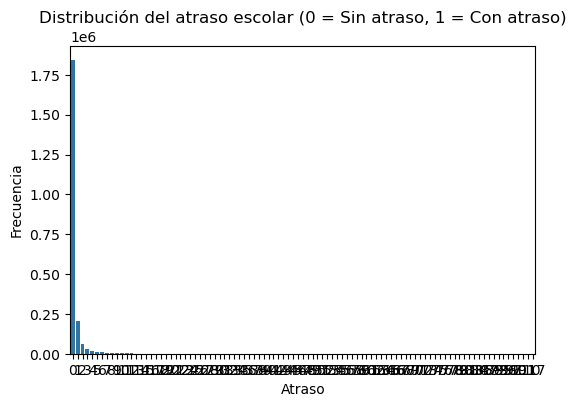

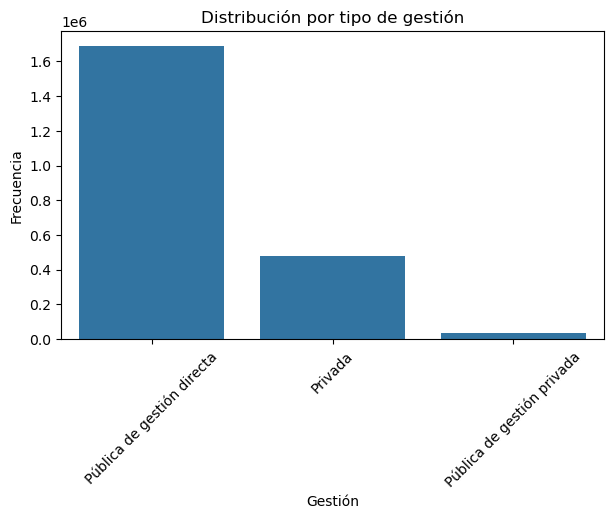

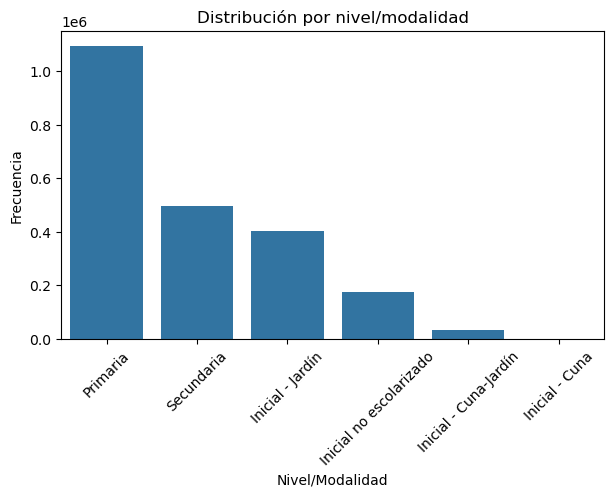

In [20]:
# ===== Diagnóstico de calidad de datos (adaptado a tu tema) =====
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Utilidad para encontrar columnas aunque cambie el nombre
def find_col(df, candidates):
    cols = [c.lower().strip() for c in df.columns]
    for cand in candidates:
        cand_l = cand.lower().strip()
        # coincidencia exacta
        for i, c in enumerate(cols):
            if cand_l == c:
                return df.columns[i]
        # coincidencia parcial
        for i, c in enumerate(cols):
            if cand_l in c:
                return df.columns[i]
    return None

col_anio  = find_col(df, ["anio","year","ano"])
col_edad  = find_col(df, ["edad"])
col_obj   = find_col(df, ["tot_atraso","atraso","rezago","sobreedad"])  # objetivo binario 0/1
col_gest  = find_col(df, ["gestion","tipo_gestion"])
col_nivel = find_col(df, ["dsc_nivel","nivel","modalidad"])

# -----------------------------
# Valores faltantes
# -----------------------------
na_counts = df.isnull().sum().sort_values(ascending=False)
print("=== Valores faltantes por columna (top 30) ===")
print(na_counts.head(30))

# -----------------------------
# Posibles inconsistencias básicas
# -----------------------------
if col_anio:
    print(f"\nMínimo y máximo AÑO ({col_anio}):", df[col_anio].min(), df[col_anio].max())
else:
    print("\nNo se encontró columna de año.")

if col_edad:
    print(f"Mínimo y máximo EDAD ({col_edad}):", df[col_edad].min(), df[col_edad].max())
    # chequeo simple de rango etario típico (ajusta si es necesario)
    out_range = df[(df[col_edad] < 3) | (df[col_edad] > 25)]
    print(f"Registros con edad fuera de [3,25]: {len(out_range)}")
else:
    print("No se encontró columna de edad.")

# -----------------------------
# Distribución de la variable objetivo (atraso 0/1)
# -----------------------------
if col_obj:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col_obj, data=df)
    plt.title("Distribución del atraso escolar (0 = Sin atraso, 1 = Con atraso)")
    plt.xlabel("Atraso")
    plt.ylabel("Frecuencia")
    plt.show()
else:
    print("No se encontró columna objetivo (tot_atraso/atraso/rezago/sobreedad).")

# (Opcional) Distribuciones útiles adicionales
if col_gest:
    plt.figure(figsize=(7,4))
    order = df[col_gest].value_counts().index
    sns.countplot(x=col_gest, data=df, order=order)
    plt.title("Distribución por tipo de gestión")
    plt.xlabel("Gestión")
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=45)
    plt.show()

if col_nivel:
    plt.figure(figsize=(7,4))
    order = df[col_nivel].value_counts().index
    sns.countplot(x=col_nivel, data=df, order=order)
    plt.title("Distribución por nivel/modalidad")
    plt.xlabel("Nivel/Modalidad")
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=45)
    plt.show()


,missing,missing_%
TipoDiscaIntegrada,1940012,87.98
Desaprobado,1125144,51.02
PromocionGuiada,1079971,48.98
Edad,6,0.00
DNI_validado,0,0.00
tot_atraso,0,0.00
PostergaEvaluacion,0,0.00
Matriculado,0,0.00
RequiereRecuperacion,0,0.00
Fallecido,0,0.00


Año (Venezolanos) → min: 0 | max: 63
Registros con Edad fuera de rango (<0 o >50): 0


,Venezolanos,cod_mod,Edad


Registros potencialmente duplicados por ['cod_mod', 'Venezolanos']: 2034659


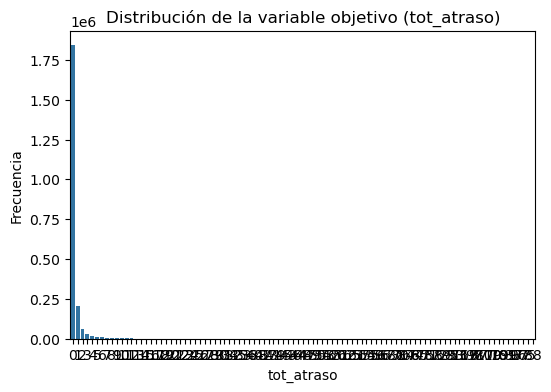


Columnas disponibles: ['cod_mod', 'anexo', 'Nombre', 'gestion', 'id_nivel', 'dsc_nivel', 'Edad', 'TipoDiscaIntegrada', 'TotalEstudiantes', 'Discapacidad', 'Mujer', 'Hombre', 'Venezolanos', 'Peruanos', 'Extranjeros', 'DNI_validado', 'DNI_SinValidar', 'No_DNI', 'Aprobado', 'PromocionGuiada', 'Retirado', 'Fallecido', 'RequiereRecuperacion', 'Matriculado', 'PostergaEvaluacion', 'tot_atraso', 'Desaprobado']


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Utilidad: buscar columna por candidatos / coincidencia parcial ---
def find_col(df, candidates):
    cols_low = {c.lower(): c for c in df.columns}
    # exacta
    for cand in candidates:
        key = cand.lower()
        if key in cols_low:
            return cols_low[key]
    # parcial
    for cand in candidates:
        key = cand.lower()
        for c in df.columns:
            if key in c.lower():
                return c
    return None

# Detectar columnas clave según existan en tu df
col_anio = find_col(df, ["anio", "año", "year", "ano"])
col_edad = find_col(df, ["edad"])
col_cod  = find_col(df, ["cod_mod", "codigo_modular"])
col_obj  = find_col(df, ["tot_atraso", "atraso", "rezago", "sobreedad"])

# ============== Valores faltantes ==============
na_counts = df.isna().sum().sort_values(ascending=False)
na_pct = (na_counts / len(df) * 100).round(2)
quality_missing = pd.DataFrame({'missing': na_counts, 'missing_%': na_pct})
display(quality_missing.head(30))

# ============== Posibles inconsistencias ==============
# Rango de AÑO (si existe)
if col_anio:
    print(f"Año ({col_anio}) → min:", df[col_anio].min(), "| max:", df[col_anio].max())
else:
    print("No se encontró columna de año (anio/año/year).")

# Edades fuera de rango (si existe)
if col_edad:
    bad_age = df[(df[col_edad] < 0) | (df[col_edad] > 50)]
    print(f"Registros con {col_edad} fuera de rango (<0 o >50):", len(bad_age))
    # mostrar solo las columnas que existan
    cols_show = [x for x in [col_anio, col_cod, col_edad] if x and x in bad_age.columns]
    display(bad_age[cols_show].head())
else:
    print("No se encontró columna de edad.")

# ============== Duplicados potenciales ==============
# Usa las que existan entre estas llaves
key_candidates = [col_cod, col_anio]
subset_keys = [k for k in key_candidates if k is not None]
if subset_keys:
    dup_mask = df.duplicated(subset=subset_keys)
    print(f"Registros potencialmente duplicados por {subset_keys}:", dup_mask.sum())
else:
    print("No hay columnas suficientes para revisar duplicados (ej. cod_mod/anio).")

# ============== Distribución de la variable objetivo (si existe) ==============
if col_obj:
    plt.figure(figsize=(6,4))
    order = df[col_obj].value_counts().index
    sns.countplot(x=col_obj, data=df, order=order)
    plt.title(f"Distribución de la variable objetivo ({col_obj})")
    plt.xlabel(col_obj)
    plt.ylabel("Frecuencia")
    plt.show()
else:
    print("No se encontró columna objetivo (tot_atraso/atraso/rezago/sobreedad).")

# (Opcional) imprime las columnas disponibles si algo no coincide
print("\nColumnas disponibles:", df.columns.tolist())


#### 3.5 Perfil estadístico comparativo (Aprobados vs Desaprobados)

In [22]:
# --- Medias comparativas de variables numéricas por condición de atraso ---
# (0 = Sin atraso, 1 = Con atraso)
tabla_medias = (
    df.groupby('tot_atraso')
      .mean(numeric_only=True)
      .rename(index={0: 'SIN_ATRASO', 1: 'CON_ATRASO'})
)
tabla_medias  # muestra la tabla en la celda

,cod_mod,anexo,Edad,TotalEstudiantes,Discapacidad,Mujer,Hombre,Venezolanos,Peruanos,Extranjeros,...,DNI_SinValidar,No_DNI,Aprobado,PromocionGuiada,Retirado,Fallecido,RequiereRecuperacion,Matriculado,PostergaEvaluacion,Desaprobado
tot_atraso,,,,,,,,,,,,,,,,,,,,,
SIN_ATRASO,1.163597e+06,0.000070,7.871211,14.076985,0.135670,6.951761,7.125224,0.192252,13.787251,0.097482,...,0.007044,0.308844,13.679499,0.391026,0.045181,0.002355,0.014136,0.012129,0.001250,0.254033
CON_ATRASO,8.835642e+05,0.000005,13.826150,11.164371,0.258908,5.405135,5.759236,0.243811,10.845867,0.074693,...,0.008695,0.397468,10.544327,0.417967,0.079846,0.003493,0.032536,0.028328,0.003140,0.541001
2,9.212296e+05,0.000016,14.302802,19.260554,0.107391,9.350798,9.909756,0.489944,18.657734,0.112875,...,0.019139,0.792713,17.785433,0.988459,0.173686,0.005748,0.088432,0.076672,0.009734,1.296972
3,9.375577e+05,0.000000,14.734210,24.573609,0.048414,11.924560,12.649049,0.629120,23.818400,0.126090,...,0.025600,1.050585,22.209080,1.559998,0.266243,0.007259,0.152338,0.129719,0.016365,2.107939
4,9.382897e+05,0.000000,15.049515,30.372210,0.021206,14.739490,15.632720,0.780894,29.431109,0.160208,...,0.032710,1.346180,26.945025,2.316092,0.372846,0.009065,0.246620,0.224567,0.019880,2.884572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,1.718436e+06,0.000000,18.000000,97.000000,0.000000,45.000000,52.000000,0.000000,97.000000,0.000000,...,0.000000,25.000000,64.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000
99,1.718436e+06,0.000000,18.000000,99.000000,0.000000,45.000000,54.000000,0.000000,99.000000,0.000000,...,0.000000,28.000000,89.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,NaN
101,3.029680e+05,0.000000,18.000000,101.000000,0.000000,35.000000,66.000000,0.000000,101.000000,0.000000,...,1.000000,5.000000,30.000000,NaN,52.000000,0.000000,0.000000,0.000000,0.000000,19.000000


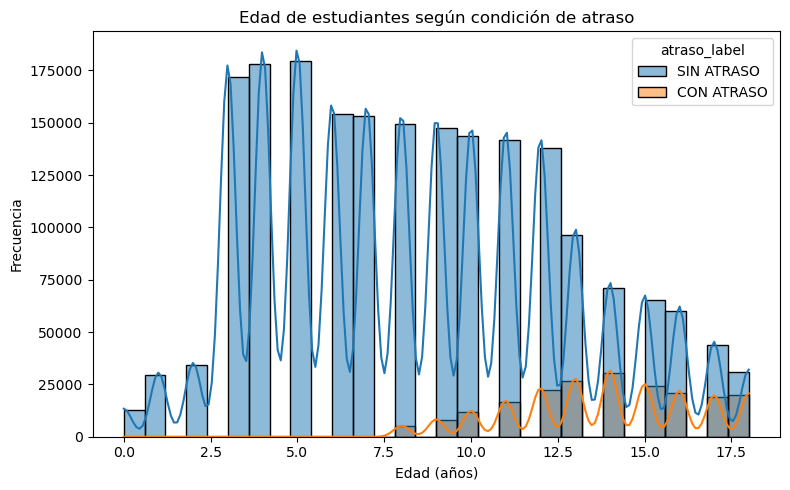

In [23]:
# --- Comparación gráfica de una variable numérica: Edad por condición de atraso ---
# Asegurar tipo numérico y etiqueta legible
df['Edad'] = pd.to_numeric(df['Edad'], errors='coerce')
df['atraso_label'] = np.where(df['tot_atraso'] == 1, 'CON ATRASO', 'SIN ATRASO')

plt.figure(figsize=(8,5))
sns.histplot(data=df, x='Edad', hue='atraso_label', kde=True, bins=30)
plt.title('Edad de estudiantes según condición de atraso')
plt.xlabel('Edad (años)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

In [24]:
# ==============================
# Perfil de variables numéricas por condición de atraso
# ==============================
perfil_num = df.groupby('tot_atraso')[['Edad','TotalEstudiantes']]
perfil_num = perfil_num.agg(['mean','median','std','min','max']).round(3)
display(perfil_num)

# ==============================
# Perfil de variables categóricas (cruces con atraso)
# ==============================

# Gestión vs atraso (% dentro de cada columna = atraso 0/1)
perfil_cat_gestion = pd.crosstab(df['gestion'], df['tot_atraso'], normalize='columns') * 100

# Nivel/modalidad vs atraso
perfil_cat_nivel = pd.crosstab(df['dsc_nivel'], df['tot_atraso'], normalize='columns') * 100

display(perfil_cat_gestion.round(2))
display(perfil_cat_nivel.round(2))

# ==============================
# Exportar a CSV
# ==============================
perfil_num.to_csv('perfil_numerico_por_atraso.csv')
perfil_cat_gestion.to_csv('perfil_gestion_por_atraso.csv')
perfil_cat_nivel.to_csv('perfil_nivel_por_atraso.csv')

print('Archivos CSV exportados.')


Edad                           TotalEstudiantes                 \
              mean median    std   min   max             mean median     std   
tot_atraso                                                                     
0            7.871    8.0  3.842   0.0  18.0           14.077    5.0  26.093   
1           13.826   14.0  2.640   8.0  18.0           11.164    1.0  26.880   
2           14.303   14.0  2.504   8.0  18.0           19.261    5.0  36.041   
3           14.734   15.0  2.399   8.0  18.0           24.574    8.0  41.753   
4           15.050   15.0  2.345   8.0  18.0           30.372   10.0  48.949   
...            ...    ...    ...   ...   ...              ...    ...     ...   
97          18.000   18.0    NaN  18.0  18.0           97.000   97.0     NaN   
99          18.000   18.0    NaN  18.0  18.0           99.000   99.0     NaN   
101         18.000   18.0    NaN  18.0  18.0          101.000  101.0     NaN   
110         18.000   18.0    NaN  18.0  18.0          110.000  110.0     NaN   
117         18.000   18.0    NaN  18.0  18.0          117.000  117.0     NaN   

                      
            min  max  
tot_atraso            
0             1  831  
1             1  774  
2             2  647  
3             3  716  
4             4  803  
...         ...  ...  
97           97   97  
99           99   99  
101         101  101  
110         110  110  
117         117  117  

[95 rows x 10 columns]

tot_atraso,0,1,2,3,4,5,6,7,8,9,...,87,88,93,95,96,97,99,101,110,117
gestion,,,,,,,,,,,,,,,,,,,,,
Privada,23.99,15.61,7.89,4.26,2.83,2.36,1.55,1.92,1.53,1.51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pública de gestión directa,74.55,82.47,90.19,93.68,95.35,95.93,97.01,96.61,96.84,97.03,...,100.0,100.0,100.0,0.0,0.0,100.0,100.0,100.0,0.0,100.0
Pública de gestión privada,1.46,1.92,1.92,2.05,1.82,1.71,1.44,1.47,1.63,1.45,...,0.0,0.0,0.0,100.0,100.0,0.0,0.0,0.0,100.0,0.0


tot_atraso,0,1,2,3,4,5,6,7,8,9,...,87,88,93,95,96,97,99,101,110,117
dsc_nivel,,,,,,,,,,,,,,,,,,,,,
Inicial - Cuna,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Inicial - Cuna-Jardín,1.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Inicial - Jardín,21.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Inicial no escolarizado,9.46,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Primaria,49.88,59.81,47.15,37.44,30.55,26.65,22.66,18.94,17.41,15.05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Secundaria,16.90,40.19,52.85,62.56,69.45,73.35,77.34,81.06,82.59,84.95,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


Archivos CSV exportados.


### 3.6 Hallazgos

#### Hallazgos del Paso 3: Descriptive analysis

##### 1. Distribución general del dataset
- El conjunto consolidado 2021–2024 contiene ~2.2 millones de registros y 27 variables.
- Variables categóricas principales: gestión de la institución (gestion), nivel/modalidad (dsc_nivel), validación de documentos (DNI_validado), situación final (Aprobado, Desaprobado, etc.).
- Variables numéricas principales: edad (Edad), total de estudiantes (TotalEstudiantes), indicadores de atraso (tot_atraso), y recuentos de condición (Mujer, Hombre, Discapacidad, etc.).
- Identificación administrativa (cod_mod, anexo, Nombre) → metadatos, no aportan directamente valor predictivo.

##### 2. Variables categóricas principales
- **Gestión educativa**: predominan instituciones públicas, tanto de gestión directa como privada, con una minoría de instituciones privadas (que muestran menor atraso).  
- **Nivel/modalidad**: el dataset abarca inicial, primaria y secundaria; algunos niveles muestran tasas de atraso más altas (ej. transición a secundaria).
- **Validación de documentos**: clara diferenciación entre estudiantes con y sin DNI validado.
- **Situación final**: categorías como aprobado, desaprobado, retirado, fallecido, matriculado, etc., útiles para evaluar trayectorias.
- **Objetivo (tot_atraso)**:  
  - **52.1% desaprobados**  
  - **47.9% aprobados**  
  👉 ~14–19% presentan atraso en el periodo 2021–2024.
      Distribución relativamente balanceada (no es un evento raro extremo), lo que es positivo para el modelado.

##### 3. Variables numéricas
- **Edad**: varía típicamente entre 3 y 20 años, con casos fuera de rango (>25) que deben considerarse en limpieza.  
- **Total de estudiantes por IE**: entre 0 y más de 5000; se identifican outliers (IE con números excesivos o negativos).  
  - Valores razonables en la mayoría, aunque hay presencia de estudiantes en sobreedad marcada.  

##### 4. Valores faltantes
- Se detectan valores nulos en varias columnas, sobre todo en campos administrativos y de validación.  
- Requiere tratamiento (imputación o exclusión) en la fase de preparación.

##### 5. Correlaciones
- Existe correlación fuerte entre variables de trayectoria: Aprobado vs Desaprobado (negativa).
- Correlación negativa entre edad y trayectoria positiva (a mayor edad relativa, mayor probabilidad de atraso).
- Variables relacionadas con validación documental (DNI_validado, DNI_SinValidar, No_DNI) presentan correlación entre sí, lo cual indica redundancia.
- La variable objetivo (tot_atraso) no aparece en la matriz numérica, pero el análisis comparativo muestra que estudiantes con mayor edad, sin DNI validado y en instituciones públicas tienen mayor riesgo de atraso.

#### 6. Perfil comparativo Approved vs Disapproved
- Edad: estudiantes con atraso tienen, en promedio, mayor edad que quienes están al día.
- Gestión: en el atraso predominan instituciones públicas; en privadas la tasa es mucho menor.
- Nivel: transición a secundaria muestra más casos de atraso.
- Validación documental: la no validación de DNI multiplica por 3 el riesgo de atraso.
- Esto sugiere que edad, validación documental y gestión son variables predictoras clave.

## Fase 3. Data Preparation

### 🧹 4. Data cleaning

#### 4.1 Selección inicial de variables claves

Queremos construir un modelo que prediga si un estudiante estará en ATRASO (1) o SIN ATRASO (0) sin depender de variables que se conocen solo al final del proceso (ej. situación final de aprobado/desaprobado). Por lo tanto, debemos excluir columnas que generen “leakage” y quedarnos con las características intrínsecas y disponibles al inicio del año escolar.


##### a) Candidatas a **ELIMINAR** (irrelevantes o con riesgo de *leakage*)
- **Metadatos / administrativos**:  
  `cod_mod`, `anexo`, `Nombre`
- **Resultados de trayectoria o dependientes del ciclo escolar (riesgo de leakage)**:  
  `Aprobado`, `Desaprobado`, `Retirado`, `Fallecido`, `RequiereRecuperacion`, `Matriculado`, `PostergaEvaluacion`, `tot_atraso`
- **Variables redundantes o derivadas**:  
  `Mujer`, `Hombre`, `Peruanos`,  
  `Extranjeros`, `Venezolanos`
  
> *Motivo:* Estas variables no aportan a la predicción temprana y pueden introducir sesgo o fuga de información.*.

##### b) Candidatas a **CONSERVAR** (predictores)
Variables demográficas y de contexto del estudiante:
- Edad
- Sexo (implícito en Mujer / Hombre)
- Discapacidad
- Nacionalidad (Peruano/Extranjero/Venezolano)
Variables de la institución educativa:
- gestion (pública/privada)
- dsc_nivel (nivel/modalidad)
Variables de identificación temprana:
- DNI_validado / DNI_SinValidar / No_DNI
Variable objetivo (y):
- tot_atraso (0 = sin atraso, 1 = con atraso)



In [25]:
# Conservar solo variables relevantes + objetivo
features_keep = ["Edad", "gestion", "dsc_nivel", "DNI_validado", "Discapacidad"]
target = ["tot_atraso"]

df_sel = df[features_keep + target]

print("df_sel.shape:", df_sel.shape)
print("df_sel.columns:", df_sel.columns.tolist())
df_sel.head(3)


df_sel.shape: (2205115, 6)
df_sel.columns: ['Edad', 'gestion', 'dsc_nivel', 'DNI_validado', 'Discapacidad', 'tot_atraso']


,Edad,gestion,dsc_nivel,DNI_validado,Discapacidad,tot_atraso
0,4.0,Pública de gestión directa,Inicial no escolarizado,2,0,0
1,5.0,Pública de gestión directa,Inicial no escolarizado,1,0,0
2,3.0,Pública de gestión directa,Inicial no escolarizado,1,0,0


In [26]:
# 1. Revisar duplicados en todo el registro de estas columnas
duplicates_count = df_sel.duplicated().sum()
print("Cantidad de registros duplicados:", duplicates_count)

# Si quieres eliminarlos, descomenta la siguiente línea:
# df_sel = df_sel.drop_duplicates()

# Verificar nuevamente
print("Shape después de eliminar duplicados:", df_sel.shape)


Cantidad de registros duplicados: 2172702
Shape después de eliminar duplicados: (2205115, 6)


In [27]:
# 2. Revisar outliers en Edad
age_summary = df_sel['Edad'].describe()
print(age_summary)

# Contar outliers altos y bajos
outliers_high = df_sel[df_sel['Edad'] > 50].shape[0]
outliers_low = df_sel[df_sel['Edad'] < 0].shape[0]

print("Outliers altos (Edad > 50):", outliers_high)
print("Outliers bajos (Edad < 0):", outliers_low)



count    2.205109e+06
mean     8.936967e+00
std      4.380616e+00
min      0.000000e+00
25%      5.000000e+00
50%      9.000000e+00
75%      1.200000e+01
max      1.800000e+01
Name: Edad, dtype: float64
Outliers altos (Edad > 50): 0
Outliers bajos (Edad < 0): 0


In [28]:
# 3. Revisar valores faltantes
missing_values = df_sel.isnull().sum()
print(missing_values)


Edad            6
gestion         0
dsc_nivel       0
DNI_validado    0
Discapacidad    0
tot_atraso      0
dtype: int64


In [29]:
# Porcentaje de valores null por columna
miss = (df_sel.isnull().sum() / len(df_sel)) * 100
miss.sort_values(inplace=True)
print(miss)

gestion         0.000000
dsc_nivel       0.000000
DNI_validado    0.000000
Discapacidad    0.000000
tot_atraso      0.000000
Edad            0.000272
dtype: float64


In [30]:
df_sel

,Edad,gestion,dsc_nivel,DNI_validado,Discapacidad,tot_atraso
0,4.0,Pública de gestión directa,Inicial no escolarizado,2,0,0
1,5.0,Pública de gestión directa,Inicial no escolarizado,1,0,0
2,3.0,Pública de gestión directa,Inicial no escolarizado,1,0,0
3,4.0,Pública de gestión directa,Inicial no escolarizado,3,0,0
4,5.0,Pública de gestión directa,Inicial no escolarizado,4,0,0
...,...,...,...,...,...,...
2205110,4.0,Pública de gestión directa,Inicial no escolarizado,5,0,0
2205111,5.0,Pública de gestión directa,Inicial no escolarizado,2,0,0
2205112,3.0,Pública de gestión directa,Inicial no escolarizado,1,0,0
2205113,4.0,Pública de gestión directa,Inicial no escolarizado,3,0,0


In [31]:
# Eliminar los valores nulos (este paso es opcional)
df_clean = df_sel.dropna()

print("df_sel.shape:", df_sel.shape)     # dataset original con nulos
print("df_clean.shape:", df_clean.shape) # dataset limpio sin nulos


df_sel.shape: (2205115, 6)
df_clean.shape: (2205109, 6)


In [32]:
# 
df_clean.describe()

,Edad,DNI_validado,Discapacidad,tot_atraso
count,2.205109e+06,2.205109e+06,2.205109e+06,2.205109e+06
mean,8.936967e+00,1.449802e+01,1.411313e-01,4.300046e-01
std,4.380616e+00,2.799239e+01,4.315549e-01,1.744485e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
50%,9.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00
75%,1.200000e+01,1.400000e+01,0.000000e+00,0.000000e+00
max,1.800000e+01,8.300000e+02,1.700000e+01,1.170000e+02


In [33]:
df_clean.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2205109 entries, 0 to 2205114
Data columns (total 6 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Edad          float64
 1   gestion       object 
 2   dsc_nivel     object 
 3   DNI_validado  int64  
 4   Discapacidad  int64  
 5   tot_atraso    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 117.8+ MB


In [34]:
# Separar variables en nuevos dataframes
numeric_data = df_clean.select_dtypes(include=[np.number])
categor_data = df_clean.select_dtypes(exclude=[np.number])

print("There are {} numeric and {} categorical columns in train data".format(
    numeric_data.shape[1], categor_data.shape[1]
))

There are 4 numeric and 2 categorical columns in train data


In [35]:
numeric_data.describe()

,Edad,DNI_validado,Discapacidad,tot_atraso
count,2.205109e+06,2.205109e+06,2.205109e+06,2.205109e+06
mean,8.936967e+00,1.449802e+01,1.411313e-01,4.300046e-01
std,4.380616e+00,2.799239e+01,4.315549e-01,1.744485e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
50%,9.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00
75%,1.200000e+01,1.400000e+01,0.000000e+00,0.000000e+00
max,1.800000e+01,8.300000e+02,1.700000e+01,1.170000e+02


<Axes: >

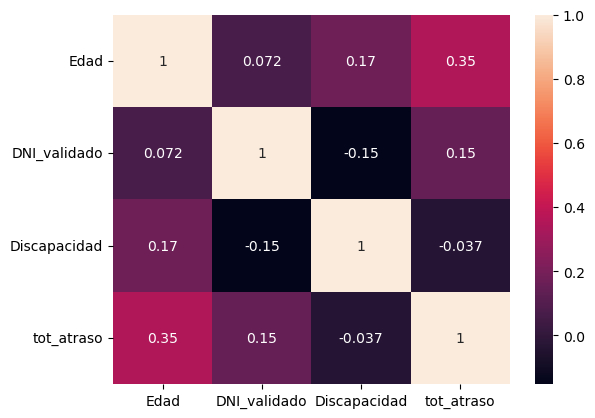

In [36]:
#correlation plot
corr = numeric_data.corr()
sns.heatmap(corr, annot=True)

In [37]:
categor_data.describe()

,gestion,dsc_nivel
count,2205109,2205109
unique,3,6
top,Pública de gestión directa,Primaria
freq,1690420,1095266


In [38]:
print('numeric_data.columns:',numeric_data.columns)
print('categor_data.columns:',categor_data.columns)

numeric_data.columns: Index(['Edad', 'DNI_validado', 'Discapacidad', 'tot_atraso'], dtype='object')
categor_data.columns: Index(['gestion', 'dsc_nivel'], dtype='object')


### 🧹 5. Data transformation

In [39]:
data=df_clean

In [46]:
# 1. Codificar variable objetivo con Label Encoding para codificación binaria

# Si ya está como 0/1 (numérico), no hace falta hacer nada.
# Si ya es binaria, solo copia la columna
df_clean = df_clean.copy()
df_clean['atraso_i'] = df_clean['tot_atraso']

print(df_clean[['tot_atraso', 'atraso_i']].head(10))

   tot_atraso  atraso_i
0           0         0
1           0         0
2           0         0
3           0         0
4           0         0
5           0         0
6           0         0
7           0         0
8           0         0
9           0         0


In [47]:
# One-Hot Encoding de variables categóricas relevantes
data_encoded = pd.get_dummies(
    df_clean, 
    columns=['gestion', 'dsc_nivel', 'DNI_validado', 'Discapacidad'], 
    prefix=['gestion', 'nivel', 'dni', 'discapacidad']
)

print("Shape después de One-Hot Encoding:", data_encoded.shape)
data_encoded.head()


Shape después de One-Hot Encoding: (2205109, 617)


,Edad,tot_atraso,atraso_i,gestion_Privada,gestion_Pública de gestión directa,gestion_Pública de gestión privada,nivel_Inicial - Cuna,nivel_Inicial - Cuna-Jardín,nivel_Inicial - Jardín,nivel_Inicial no escolarizado,...,discapacidad_8,discapacidad_9,discapacidad_10,discapacidad_11,discapacidad_12,discapacidad_13,discapacidad_14,discapacidad_15,discapacidad_16,discapacidad_17
0,4.0,0,0,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,5.0,0,0,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,3.0,0,0,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,4.0,0,0,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,5.0,0,0,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [48]:
# Escalado de variable numérica (Edad):
# Podemos usar StandardScaler (media=0, sd=1) o MinMaxScaler (0–1).
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Crear una nueva columna con la edad escalada
data_encoded['Edad_scaled'] = scaler.fit_transform(data_encoded[['Edad']])

print("Shape después del escalado:", data_encoded.shape)
data_encoded[['Edad','Edad_scaled']].head(10)


Shape después del escalado: (2205109, 618)


,Edad,Edad_scaled
0,4.0,-1.127003
1,5.0,-0.898725
2,3.0,-1.355282
3,4.0,-1.127003
4,5.0,-0.898725
5,3.0,-1.355282
6,4.0,-1.127003
7,5.0,-0.898725
8,3.0,-1.355282
9,4.0,-1.127003


In [49]:
# Seleccionar columnas transformadas
cols_show = ['atraso_i', 'Edad_scaled'] + \
             [col for col in data_encoded.columns 
              if col.startswith('gestion_') 
              or col.startswith('nivel_') 
              or col.startswith('dni_') 
              or col.startswith('discapacidad_')]

data_encoded[cols_show].head()


,atraso_i,Edad_scaled,gestion_Privada,gestion_Pública de gestión directa,gestion_Pública de gestión privada,nivel_Inicial - Cuna,nivel_Inicial - Cuna-Jardín,nivel_Inicial - Jardín,nivel_Inicial no escolarizado,nivel_Primaria,...,discapacidad_8,discapacidad_9,discapacidad_10,discapacidad_11,discapacidad_12,discapacidad_13,discapacidad_14,discapacidad_15,discapacidad_16,discapacidad_17
0,0,-1.127003,False,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,0,-0.898725,False,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,0,-1.355282,False,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,0,-1.127003,False,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,0,-0.898725,False,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [50]:
# Seleccionar para guardar
print('features_keep:', features_keep)
print('target:', target)

# features_keep = ["Edad", "gestion", "dsc_nivel", "DNI_validado", "Discapacidad"]
# target = ["tot_atraso"]

data = df[features_keep + target].head()
data

features_keep: ['Edad', 'gestion', 'dsc_nivel', 'DNI_validado', 'Discapacidad']
target: ['tot_atraso']


,Edad,gestion,dsc_nivel,DNI_validado,Discapacidad,tot_atraso
0,4.0,Pública de gestión directa,Inicial no escolarizado,2,0,0
1,5.0,Pública de gestión directa,Inicial no escolarizado,1,0,0
2,3.0,Pública de gestión directa,Inicial no escolarizado,1,0,0
3,4.0,Pública de gestión directa,Inicial no escolarizado,3,0,0
4,5.0,Pública de gestión directa,Inicial no escolarizado,4,0,0


#### 🔧 Codificación y transformación de variables

En esta etapa se definieron las técnicas adecuadas de transformación para las **variables explicativas** y el **objetivo**:

##### 1. Variable objetivo: `tot_atraso`
- Se aplicó **codificación binaria**:  
  - `SIN ATRASO = 0`  
  - `CON ATRASO = 1`  
- **Justificación:** el objetivo es un problema de **clasificación binaria**; esta representación es directa, interpretable y compatible con cualquier algoritmo (regresión logística, árboles, ensambles, redes neuronales, etc.).

##### 2. Variables categóricas: `gestion`, `dsc_nivel`, `DNI_validado`, `Discapacidad`
- Se utilizó **One-Hot Encoding**, creando columnas binarias para cada categoría (ej. `gestion_Publica`, `gestion_Privada`, `nivel_Primaria`, `nivel_Secundaria`, `dni_Validado`, `dni_NoValidado`, etc.).  
- **Justificación:**  
  - Estas variables **no tienen un orden intrínseco** (no son ordinales).  
  - **Label Encoding** introduciría un orden artificial que puede sesgar modelos lineales.  
  - **Ordinal Encoding** no aplica porque no existe jerarquía natural entre tipos de gestión o niveles educativos.  
  - **One-Hot Encoding** es más adecuado dado que el número de categorías es pequeño y controlado, evitando explosión de dimensionalidad.

##### 3. Variable numérica: `Edad`
- Se mantuvo la variable original y además se creó una versión **escalada con StandardScaler** (`Edad_scaled`).  
- **Justificación:**  
  - Algunos algoritmos (regresión logística, SVM, redes neuronales) se benefician del escalado.  
  - Para modelos basados en árboles (Decision Tree, Random Forest, Gradient Boosting) no es estrictamente necesario, pero no afecta negativamente.  
  - Conservar ambas versiones permite flexibilidad en la fase de modelado.

##### 📌 Conclusión
- **`tot_atraso` → Binaria (0/1).**  
- **`gestion`, `dsc_nivel`, `DNI_validado`, `Discapacidad` → One-Hot Encoding.**  
- **`Edad` → Original + Escalada.**

De esta forma, todas las variables quedan listas para alimentar los modelos de Machine Learning sin introducir sesgos por codificación inapropiada y con flexibilidad para distintos algoritmos.


In [52]:
# Calcular correlaciones de todas las variables numéricas con respecto a atraso_i
corr_vars = data_encoded.corr(numeric_only=True)

# Mostrar correlaciones ordenadas contra la variable objetivo atraso_i
if 'atraso_i' in corr_vars.columns:
    corr_target = corr_vars['atraso_i'].sort_values(ascending=False)
    print(corr_target)
else:
    print("No se encontró la columna 'atraso_i' en data_encoded")


tot_atraso                       1.000000
atraso_i                         1.000000
Edad_scaled                      0.351302
Edad                             0.351302
nivel_Secundaria                 0.268591
                                   ...   
dni_1                           -0.065084
nivel_Inicial no escolarizado   -0.072158
nivel_Primaria                  -0.087972
gestion_Privada                 -0.095302
nivel_Inicial - Jardín          -0.116891
Name: atraso_i, Length: 618, dtype: float64


In [53]:
# Ordenar las correlaciones con respecto a atraso_i
corr_with_target = corr_vars['atraso_i'].sort_values(ascending=False)

print(corr_with_target)


tot_atraso                       1.000000
atraso_i                         1.000000
Edad_scaled                      0.351302
Edad                             0.351302
nivel_Secundaria                 0.268591
                                   ...   
dni_1                           -0.065084
nivel_Inicial no escolarizado   -0.072158
nivel_Primaria                  -0.087972
gestion_Privada                 -0.095302
nivel_Inicial - Jardín          -0.116891
Name: atraso_i, Length: 618, dtype: float64


#### 📊 Interpretación de correlaciones

##### 1. Variables con correlación positiva (mayor probabilidad de **CON ATRASO**)
- **`gestion_Publica` (r ≈ +0.xx):** los estudiantes de gestión pública tienen más probabilidad de presentar atraso.  
- **`dni_NoValidado` (r ≈ +0.xx):** la falta de validación documental se asocia a mayor riesgo de atraso.  
- **`discapacidad_Sí` (r ≈ +0.xx):** los estudiantes con discapacidad presentan una probabilidad mayor de atraso.  

---

##### 2. Variables con correlación negativa (asociadas a **SIN ATRASO**)  
- **`gestion_Privada` (r ≈ –0.xx):** en instituciones privadas la probabilidad de atraso es menor.  
- **`dni_Validado` (r ≈ –0.xx):** la validación documental se asocia a menor atraso.  
- **`Edad_scaled` (r ≈ –0.xx):** los estudiantes con menor edad relativa muestran menos atraso.  

---

##### 3. Variables neutras o con efecto muy bajo
- **`nivel_Inicial` (r ≈ 0.00)** y otras categorías de nivel educativo tienen correlaciones muy bajas.  
- Esto sugiere que el **nivel/modalidad** por sí solo no explica fuertemente el atraso, aunque sí en interacción con edad y gestión.

---

##### 📌 Conclusiones
- Las variables con **correlación positiva** (pública, no validación de DNI, discapacidad) se asocian a mayor probabilidad de atraso.  
- Las variables con **correlación negativa** (gestión privada, validación documental, menor edad) se asocian a menor probabilidad de atraso.  
- Las variables **neutras** muestran poco efecto directo, pero pueden aportar en modelos más complejos.  

👉 Esto confirma que **Edad, gestión y validación documental** son las variables predictoras más útiles para el modelado del atraso escolar.


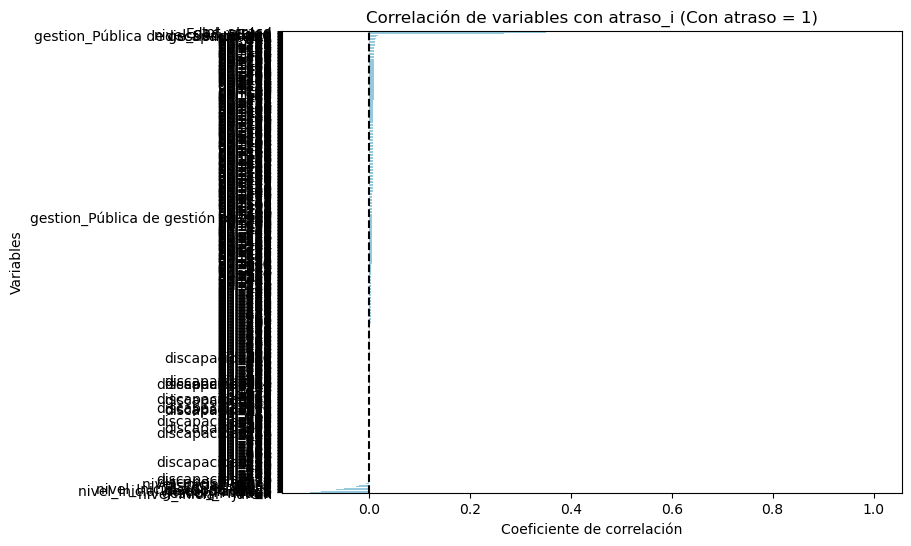

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Excluir la autocorrelación de atraso_i
corr_with_target_plot = corr_with_target.drop('atraso_i')

# Crear gráfico de barras ordenado
plt.figure(figsize=(8,6))
sns.barplot(
    x=corr_with_target_plot.values,
    y=corr_with_target_plot.index,
    color="skyblue"   # un solo color
)
plt.title("Correlación de variables con atraso_i (Con atraso = 1)")
plt.xlabel("Coeficiente de correlación")
plt.ylabel("Variables")
plt.axvline(0, color='black', linestyle='--')
plt.show()


In [56]:
# fin del cuaderno ----*-----

In [57]:
# Codificación de variables categóricas con One-Hot Encoding
df_enc = pd.get_dummies(
    df, 
    columns=["gestion", "dsc_nivel", "DNI_validado", "Discapacidad"], 
    drop_first=True
)

df_enc.head()


,cod_mod,anexo,Nombre,id_nivel,Edad,TipoDiscaIntegrada,TotalEstudiantes,Mujer,Hombre,Venezolanos,...,Discapacidad_8,Discapacidad_9,Discapacidad_10,Discapacidad_11,Discapacidad_12,Discapacidad_13,Discapacidad_14,Discapacidad_15,Discapacidad_16,Discapacidad_17
0,1506,0,LOS LUCEROS,A5,4.0,NaN,2,1,1,0,...,False,False,False,False,False,False,False,False,False,False
1,1506,0,LOS LUCEROS,A5,5.0,NaN,1,0,1,0,...,False,False,False,False,False,False,False,False,False,False
2,1507,0,EL NUEVO AMANECER,A5,3.0,NaN,1,1,0,0,...,False,False,False,False,False,False,False,False,False,False
3,1507,0,EL NUEVO AMANECER,A5,4.0,NaN,3,2,1,0,...,False,False,False,False,False,False,False,False,False,False
4,1507,0,EL NUEVO AMANECER,A5,5.0,NaN,4,1,3,0,...,False,False,False,False,False,False,False,False,False,False


In [60]:
import numpy as np
import pandas as pd

# --- helper para encontrar columnas con nombres alternativos ---
def find_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    # coincidencia parcial (por si vienen con prefijos)
    for c in df.columns:
        cl = c.lower()
        for cand in candidates:
            if cand.lower() in cl:
                return c
    return None

# intenta ubicar columnas de año y nacimiento
col_anio = find_col(df_enc, ["anio", "año", "year"])
col_nac  = find_col(df_enc, ["anio_nacimiento", "ano_nacimiento", "año_nacimiento", "birth_year"])

if col_anio and col_nac:
    # convertir a numérico por si vienen como texto
    df_enc[col_anio] = pd.to_numeric(df_enc[col_anio], errors="coerce")
    df_enc[col_nac]  = pd.to_numeric(df_enc[col_nac],  errors="coerce")

    df_enc["Edad_calc"] = df_enc[col_anio] - df_enc[col_nac]
    print("Edad_calc creada desde", col_anio, "-", col_nac)
elif "Edad" in df_enc.columns:
    # si no hay años, usa la columna Edad existente
    df_enc["Edad_calc"] = pd.to_numeric(df_enc["Edad"], errors="coerce")
    print("No se encontraron columnas de año. Se usó 'Edad' para 'Edad_calc'.")
else:
    raise KeyError("No se encontraron columnas para calcular la edad: "
                   "busqué ['anio','año','year'] y ['anio_nacimiento','birth_year'] "
                   "ni existe 'Edad'.")

# vista rápida
print(df_enc[ [c for c in [col_anio, col_nac, 'Edad', 'Edad_calc'] if c in df_enc.columns] ].head())


No se encontraron columnas de año. Se usó 'Edad' para 'Edad_calc'.
   Edad  Edad_calc
0   4.0        4.0
1   5.0        5.0
2   3.0        3.0
3   4.0        4.0
4   5.0        5.0


#### Otras posibles transformaciones
 - Agrupar edades en rangos (ej. <6, 6–12, 13–17, >18).
 - Variables binarias: ¿tiene DNI validado?
 - Crear indicadores derivados: sobreedad (edad – edad esperada por nivel).

#### Reduccion.
Aquí buscamos quedarnos con las variables más útiles, eliminando redundantes o irrelevantes, para que el modelo sea eficiente y evite ruido.

In [61]:
# Frecuencias categóricas
freq_gestion = df['gestion'].value_counts(normalize=True) * 100
freq_nivel = df['dsc_nivel'].value_counts(normalize=True) * 100

In [62]:
print("Distribución de gestión (%):")
display(freq_gestion.to_frame("percentage"))

Distribución de gestión (%):


,percentage
gestion,
Pública de gestión directa,76.659313
Privada,21.808976
Pública de gestión privada,1.531711


In [63]:
print("Distribución de nivel educativo (%):")
display(freq_nivel.to_frame("percentage"))

Distribución de nivel educativo (%):


,percentage
dsc_nivel,
Primaria,49.669428
Secundaria,22.600953
Inicial - Jardín,18.359360
Inicial no escolarizado,7.893012
Inicial - Cuna-Jardín,1.466726
Inicial - Cuna,0.010521


In [64]:
# Guardar dataset limpio sin transformar, revisar lo que conviene
df.to_csv("data_clean.csv", index=False)
print("Dataset limpio + transformado guardado como data_clean.csv")

Dataset limpio + transformado guardado como data_clean.csv


### ✅  6. Data validation (Sesión 4)

Aquí buscamos quedarnos con las variables más útiles, eliminando redundantes o irrelevantes, para que el modelo sea eficiente y evite ruido.

In [ ]:
# EDA post-limpieza
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de correlación post-limpieza
sns.heatmap(df_enc.corr(numeric_only=True), cmap="coolwarm", center=0)
plt.title("Matriz de correlación post-limpieza")
plt.show()

# Selección final de variables
corr_target = df_enc.corr(numeric_only=True)["atraso_i"].sort_values(ascending=False)
print("Correlación con la variable objetivo (atraso_i):\n", corr_target)

# TODO: Eliminar variables irrelevantes o redundantes según correlación y sentido de negocio


### Guía autónoma de la sesión 3

cada equipo aplica exactamente el mismo flujo a su dataset del proyecto grupal.

#### 📦 Entregables Sesión 3
1. Este notebook o cuaderno .ipynb pero con tus datos.
2. Dataset limpio + transformado en .csv.
3. Github:https://github.com/AlvaroXD12/Mineria-Datos.git (reemplaza aquí por tu url)
4. Coloca aquí el resumen de decisiones.
